<a href="https://colab.research.google.com/github/anaapbernardo/Bootcamp_DataScience/blob/main/Ana_Bernardo_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Author: Ana Paula da Silva Bernardo*

[LinkedIn](https://www.linkedin.com/in/ana-paula-sbernardo/)

[GitHub](https://github.com/anaapbernardo)

# Summary

This project is an analysis of COVID cases in Paulínia - São Paulo. 

The data were downloaded from the Government website: https://covid.saude.gov.br/ 

*P.S.: this notebook works for any other Brazilian city, it is only necessary to review the results, ARIMA order, and conclusions.*

# Introduction

**COVID-19**

COVID-19 is a infectious disease caused by the coronavirus (SARS-CoV-2).

The transmition is mainly through droplets of saliva or discharge from the nose when an infected person coughs or sneezes.

The following measures are recommended to prevent infection and to slow transmission of COVID-19:

- Wash your hands regularly with soap and water, or clean them with alcohol-based hand sanitizer.
- Avoid touching your face.
- Cover your mouth and nose when coughing or sneezing.
- Stay home if you feel unwell.
- Practice physical distancing.

<font size=2>*Source:* https://www.who.int/health-topics/coronavirus#tab=tab_1



---


**Vaccines**

Vaccines are the safest way to achieve the immunitazion of people around the world. Vaccines are a technology that humanity has often relied on in the past to bring down the death toll of infectious diseases.

The COVID-19 vaccines were developed in record time, within less than 12 months after the beginning of the COVID-19 pandemic. Several research teams working hard in its development and approval. Now the challenge is to make these vaccines available to people around the world. 

<font size=2>*Source:* https://ourworldindata.org/covid-vaccinations



---


**Brazil**

Brazil is the third country with the highest number of COVID-19 cases in the World, with 9,599,565* cases confirmed.
The Brazilian region with the most cases is the Southeast (3,490,947* accumulated confirmed cases). In this region, São Paulo state is the one with the highest numbers (1,864,977* accumulated confirmed cases). These numbers were expected, as the Southeast has the largest population in the country, likewise São Paulo state.


<font size=2>*Source:* https://susanalitico.saude.gov.br/extensions/covid-19_html/covid-19_html.html (*February 10, 2021)

---

**Paulínia-SP**

Paulínia is a small city in São Paulo state, with 106,776 inhabitants (IBGE, 2018). I lived in this city for almost my entire life, so I decided to evaluate the numbers of COVID-19 cases here, so I can be able to understand the current situation, also share it with family and friends who live in Paulínia.


# Preliminary Analysis

## Initial Procedures

### Importing packages, libraries, and ignore warnings

In [ ]:
# Install package pmdarima

!pip install pmdarima

In [ ]:
# Libraries used

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

In [ ]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

### Dataset url

In [ ]:
dataset_covid = '/content/drive/MyDrive/Bootcamp Data Science/Mod4 - Time Series/HIST_PAINEL_COVIDBR_01fev2021.csv'

### Functions

In [ ]:
# Variables

selected_columns = ['data', 'municipio', 'semanaEpi', 'populacaoTCU2019', 
                    'casosAcumulado', 'casosNovos', 'obitosAcumulado', 
                    'obitosNovos']

map_columns = {'data': 'date',
               'municipio': 'city',
               'semanaEpi': 'weekEpi', 
               'populacaoTCU2019': 'population', 
               'casosAcumulado': 'casesAccumulated', 
               'casosNovos': 'casesNew', 
               'obitosAcumulado': 'deathsAccumulated', 
               'obitosNovos': 'deathsNew'}

In [ ]:
def create_new_df(df: pd.DataFrame, city_name: str, 
                  columns: list, columns_dict: dict):

  #Create new df, clean, and set index
  new_df = df[df['municipio'] == city_name]
  new_df = new_df.reset_index(drop=True)
  new_df = new_df[columns]
  new_df = new_df.rename(columns_dict, axis=1)

  #Set types
  new_df['date'] = pd.to_datetime(new_df['date'], format='%Y-%m-%d')
  new_df['population'] = new_df['population'].astype(int)

  #Create year and month columns
  new_df['year'] = new_df['date'].dt.year
  new_df['month'] = new_df['date'].dt.month

  return new_df

In [ ]:
def create_two_subplots(title: str, df: pd.DataFrame,
                        y1: str, ylabel1: str,
                        y2: str, ylabel2: str):
  
  plt.figure(figsize=(15,10))

  #Plot number 1
  ax1 = plt.subplot(2,1,1)
  sns.lineplot(x='date', y=y1, data=df, linewidth=2)
  plt.title(title, fontsize=18)
  plt.xlabel('Date (Year-Month)', fontsize=12)
  plt.ylabel(ylabel1, fontsize=14)
  

  #Plot number 2
  ax2 = plt.subplot(2,1,2)
  sns.lineplot(x='date', y=y2, data=df, linewidth=3)
  plt.xlabel('Date (Year-Month)', fontsize=12)
  plt.ylabel(ylabel2, fontsize=14)

  return plt.show()

In [ ]:
def create_forecast_plot(prediction_column: str, forecast_label: str, 
                         color_code: str, title: str):

  plt.figure(figsize=(15,5))

  sns.lineplot(x='date', y='casesNew', data=data_train, label='Real data')
  sns.lineplot(x='date', y='casesNew', data=data_test, label='Real test data')
  sns.lineplot(x='date', y=prediction_column, data=data_test, 
               label=forecast_label, color=color_code)

  plt.title(title, fontsize=18)
  plt.ylabel('New Cases', fontsize=14)
  plt.xlabel('Data (Year-Month)', fontsize=12)
  plt.legend()

  return plt.show()

## Exploratory Analysis

In [ ]:
covid_br = pd.read_csv(dataset_covid, sep=';', engine='python')

In [ ]:
covid_city = create_new_df(covid_br, 'Paulínia', 
                           selected_columns, map_columns)
covid_city.head()

,date,city,weekEpi,population,casesAccumulated,casesNew,deathsAccumulated,deathsNew,year,month
0,2020-03-27,Paulínia,13,109424,0,0,0,0,2020,3
1,2020-03-28,Paulínia,13,109424,1,1,0,0,2020,3
2,2020-03-29,Paulínia,14,109424,1,0,0,0,2020,3
3,2020-03-30,Paulínia,14,109424,1,0,0,0,2020,3
4,2020-03-31,Paulínia,14,109424,1,0,0,0,2020,3


In [ ]:
total_cases = covid_city['casesNew'].sum()
total_deaths = covid_city['deathsNew'].sum()

print(f'Total: \n Cases: {total_cases} \n Deaths: {total_deaths}')

Total: 
 Cases: 7598 
 Deaths: 106


# Time Series Analysis

### Data Visualization

Starting with data visualization of the number of cases and deaths due to COVID-19 in Paulínia city.

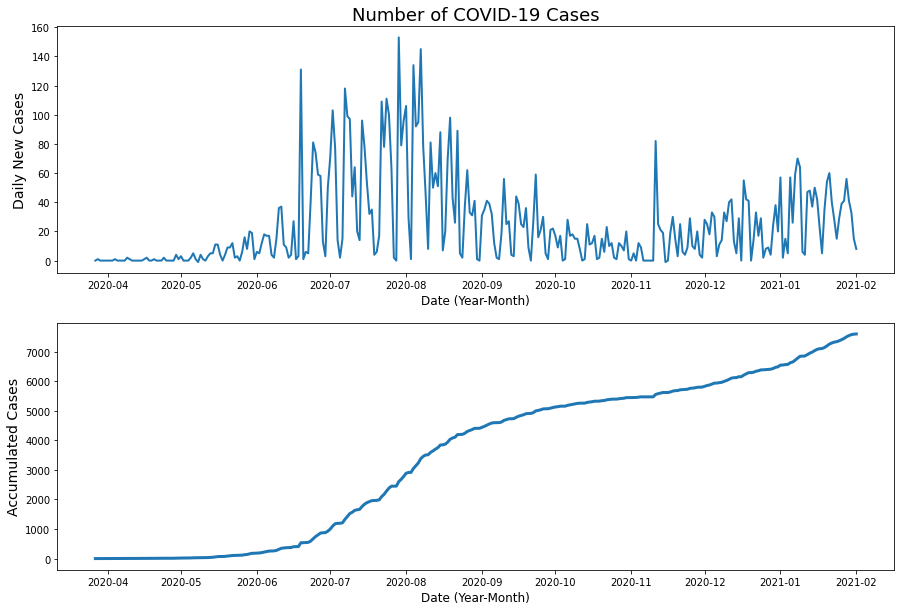

In [ ]:
cases = create_two_subplots('Number of COVID-19 Cases', covid_city,
                            'casesNew', 'Daily New Cases',
                            'casesAccumulated', 'Accumulated Cases')

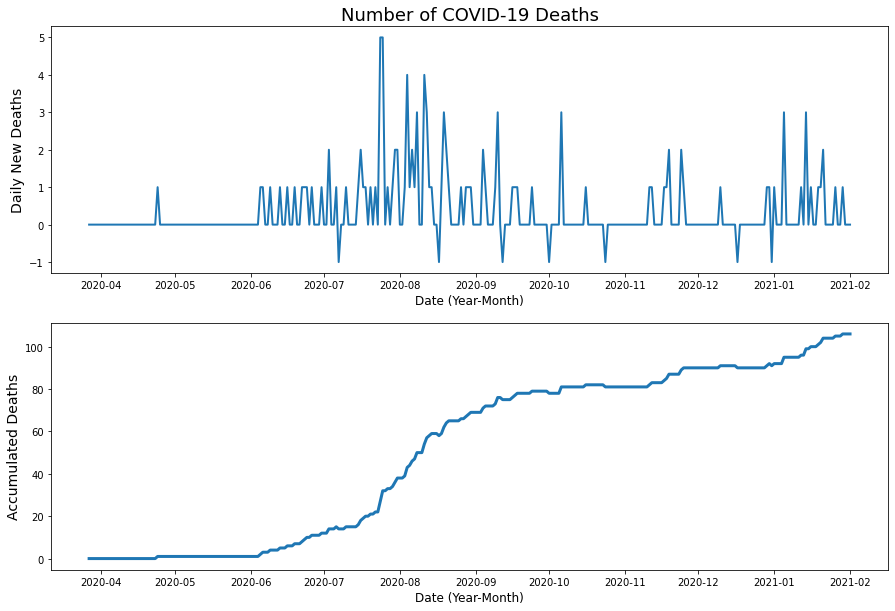

In [ ]:
deaths = create_two_subplots('Number of COVID-19 Deaths', covid_city,
                             'deathsNew', 'Daily New Deaths',
                             'deathsAccumulated', 'Accumulated Deaths')

Looking at the graphs above, it is possible to verify that the peak of COVID-19 in Paulínia was in August 2020, and the lowest number occurred in November. However, cases have been increasing since December and, if preventive measures are not taken, these numbers can increase exponentially, with another peak higher than the first one.

### Seasonal Decompose

In [ ]:
# Time Series Seasonal Decompose - additive model

covid_city.set_index('date', inplace=True)
covid_city_decompose = seasonal_decompose(covid_city['casesNew'])

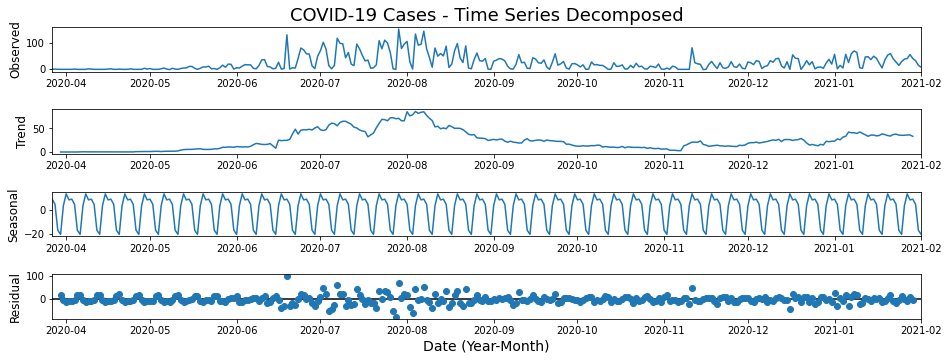

In [ ]:
# Time Series Decompose Plot

figure = covid_city_decompose.plot();
figure.set_size_inches(15, 5)

figure.axes[0].set_title('COVID-19 Cases - Time Series Decomposed', fontsize=18)

figure.axes[0].set_ylabel('Observed', fontsize=12)
figure.axes[1].set_ylabel('Trend', fontsize=12)
figure.axes[2].set_ylabel('Seasonal', fontsize=12)
figure.axes[3].set_ylabel('Residual', fontsize=12)

figure.axes[3].set_xlabel('Date (Year-Month)', fontsize=14);

The time series decompose indicate a seasonality within each week, but no trend.

**Obs.:** In this case, as the dataset has some zeros, the multiplicative model is not appropriate.

## Stationarity Test

Before starting the forecast, it is important to check whether the data is stationary or not. Stationarity can be verified using statistical tests such as Dickey-Fuller, KPSS and Philips Perron. Here, I chose to use Dickey-Fuller (adfuller).

In [ ]:
stationary_test = adfuller(x=covid_city['casesNew'])

print(f'Test statistic: {"%.2f" % stationary_test[0]}')
print(f'p-Value: {"%.2f" % stationary_test[1]}')
print(f'Critical values: {stationary_test[4]}')

Test statistic: -1.82
p-Value: 0.37
Critical values: {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}


The time series data of COVID-19 cases in Paulínia is non-stationary (p-value>0.05 and critical values lower than test statistic).

Therefore, it is necessary a model that transforms the data into a stationary time series.

# Forecast Models

As it was previously checked, the current time series about COVID-19 in Paulínia city is non-stationary and has a seasonality effect. Therefore, the forecasting models chosen need to differentiate the time series and consider the seasonality.

## ARIMA



Autoregressive Integrated Moving Average (ARIMA) is a common time series model to describe the correlations within the data.

The ARIMA models combine autoregressive (AR - p) and moving average (MA - q) approaches. Also, the models require the time series to be stationary, so differencing (I - d) the time series it is a necessary step.

<font size=2> *Source:* https://towardsdatascience.com/an-overview-of-time-series-forecasting-models-a2fa7a358fcb

### Autocorrelation and Partil Autocorrelation

The Autocorrelation (acf) and Partil Autocorrelation are used to measure the correlation within the data. ACF determine the parameter 'q' and the PCAF the parameter 'p'.

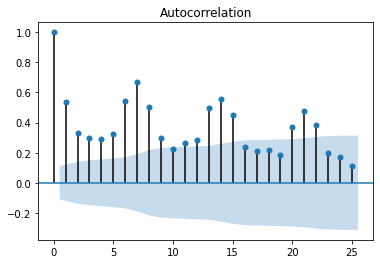

In [ ]:
# Autocorrelation

plot_acf(covid_city['casesNew']);

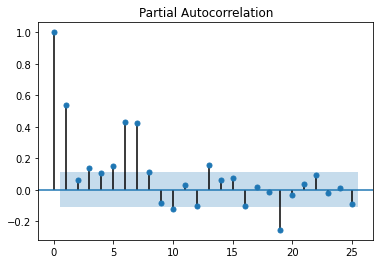

In [ ]:
# Partial Autocorrelation

plot_pacf(covid_city['casesNew']);

### ARIMA Model

In [ ]:
# Train and test data

data_train = covid_city.query('year != 2021')
data_test = covid_city.query('year == 2021')

In [ ]:
# Set and train the ARIMA model

# Considering the ACF and PACF, the best order was p=2, d=1, q=7
arima_model = ARIMA(data_train['casesNew'].values.astype('float32'), 
                    order=[2, 1, 7])
trained_arima_model = arima_model.fit()
prediction = trained_arima_model.forecast(32)[0]
data_test['prediction'] = prediction

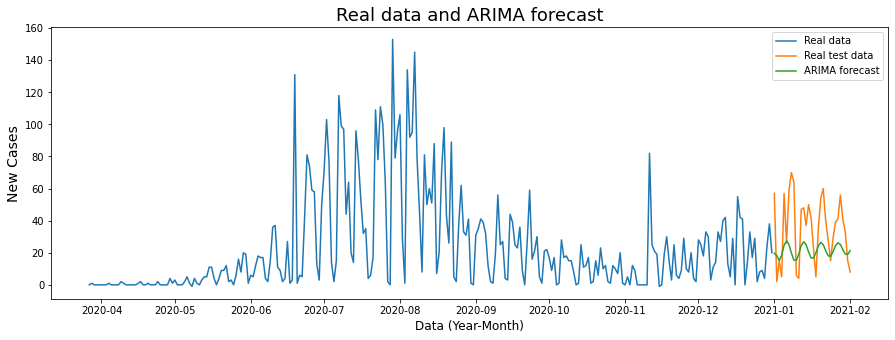

In [ ]:
arima_plot = create_forecast_plot('prediction', 'ARIMA forecast', '#2CA02C',
                                  'Real data and ARIMA forecast')

According to the graph above, it is possible to notice that the model predicted some oscillation in the data, however, it is not accentuated as the real data. Also, the model can not predict the trend of increase in the numbers of COVID-19 cases.

## AUTO ARIMA

The AUTO ARIMA model is basically and ARIMA model that will generate the optimal p,d,q values itself, based on the AIC (Akaike information criterion).

In [ ]:
# AUTO ARIMA model

autoarima_model = auto_arima(data_train['casesNew'].values, error_action='ignore',
                             trace=True, m=32)
prediction_autoarima = autoarima_model.predict(32)
data_test["predictionAutoarima"] = prediction_autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[32] intercept   : AIC=2541.944, Time=5.86 sec
 ARIMA(0,1,0)(0,0,0)[32] intercept   : AIC=2676.220, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[32] intercept   : AIC=2650.667, Time=1.03 sec
 ARIMA(0,1,1)(0,0,1)[32] intercept   : AIC=2569.054, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[32]             : AIC=2674.221, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[32] intercept   : AIC=2540.275, Time=4.04 sec
 ARIMA(2,1,2)(0,0,0)[32] intercept   : AIC=2541.664, Time=0.42 sec
 ARIMA(2,1,2)(0,0,2)[32] intercept   : AIC=2541.782, Time=15.39 sec
 ARIMA(2,1,2)(1,0,0)[32] intercept   : AIC=2540.032, Time=4.01 sec
 ARIMA(2,1,2)(2,0,0)[32] intercept   : AIC=2541.898, Time=15.62 sec
 ARIMA(2,1,2)(2,0,1)[32] intercept   : AIC=2543.789, Time=26.24 sec
 ARIMA(1,1,2)(1,0,0)[32] intercept   : AIC=2558.166, Time=2.38 sec
 ARIMA(2,1,1)(1,0,0)[32] intercept   : AIC=2553.167, Time=2.25 sec
 ARIMA(3,1,2)(1,0,0)[32] intercept   : AIC=2556.973, Time=4.91 sec
 ARIMA(2,1,3)(1,

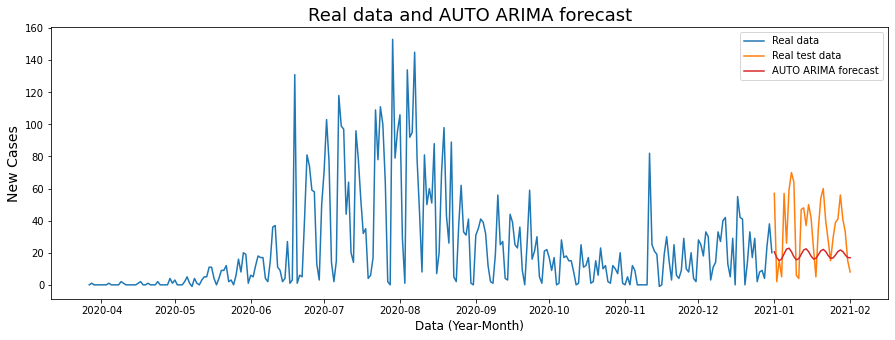

In [ ]:
autoarima_plot = create_forecast_plot('predictionAutoarima', 'AUTO ARIMA forecast', 
                                      '#D62728', 'Real data and AUTO ARIMA forecast')

AUTO ARIMA showed a similar result to ARIMA.

## Holt-Winters Exponential Smoothing

Holt-Winters Exponential Smoothing is another time series forecast method for univariate data, and can be considered an alternative to ARIMA methods. Holt-Winters Exponential Smoothing is also known as Triple Exponential Smoothing, and it supports seasonality effect.

<font size=2> *Source:* https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

In [ ]:
# Holt Winters forecast

holtWinters_model = ExponentialSmoothing(data_train['casesNew'], freq='D', 
                                         trend='add', seasonal='add')
trained_holtWinters = holtWinters_model.fit()
prediction_holtWinters = trained_holtWinters.forecast(32)
data_test['predictionHoltWinters'] = prediction_holtWinters

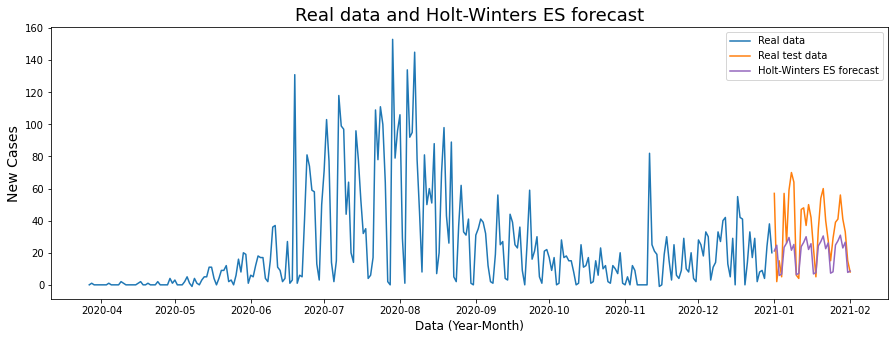

In [ ]:
holtWinters_plot = create_forecast_plot('predictionHoltWinters', 'Holt-Winters ES forecast',
                                        '#9467bd', 'Real data and Holt-Winters ES forecast')

The Holt-Winters Exponential Smoothing had a more accurate prediction, with higher peaks and a slightly increasing trend.

## Comparing the forecast models

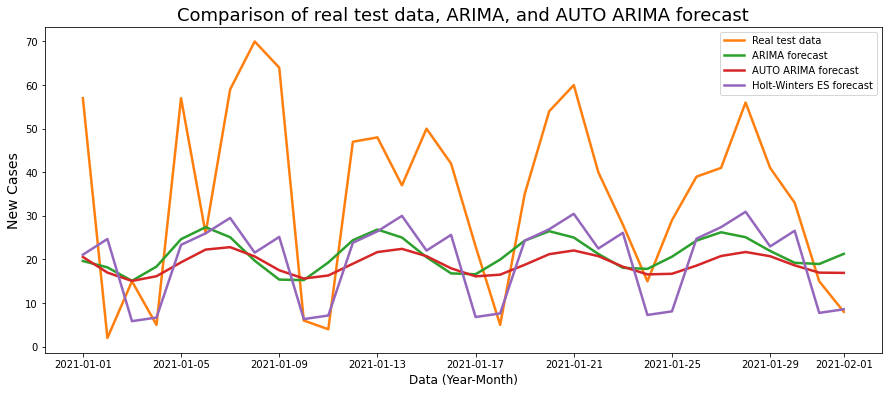

In [ ]:
# Comparison of test data, ARIMA, AUTO ARIMA, and Holt Winters

plt.figure(figsize=(15,6))

sns.lineplot(x='date', y='casesNew', data=data_test, label='Real test data', 
             color='#ff7f0e', linewidth=2.5)
sns.lineplot(x='date', y='prediction', data=data_test, label='ARIMA forecast', 
             color='#2ca02c', linewidth=2.5)
sns.lineplot(x='date', y='predictionAutoarima', data=data_test, label='AUTO ARIMA forecast', 
             color='#d62728', linewidth=2.5)
sns.lineplot(x='date', y='predictionHoltWinters', data=data_test, 
             label='Holt-Winters ES forecast', color='#9467bd', linewidth=2.5)

plt.title('Comparison of real test data, ARIMA, and AUTO ARIMA forecast', fontsize=18)
plt.ylabel('New Cases', fontsize=14)
plt.xlabel('Data (Year-Month)', fontsize=12)
plt.legend(loc='upper right')

plt.show()

Comparing the tree forecasting methods used, the Holt-Winters Exponential Smoothing was clearly the best predictive method.

In [ ]:
# Mean Squared Error (MSE)

autoarima_results = mean_squared_error(data_test['casesNew'], data_test['predictionAutoarima'])
arima_results = mean_squared_error(data_test['casesNew'], data_test['prediction'])
holtWinters_results = mean_squared_error(data_test['casesNew'], data_test['predictionHoltWinters'])

print(f'MSE: \n Autoarima:{"%.2f" % autoarima_results} \n Arima:{"%.2f" % arima_results} \n Holt-Winters ES:{"%.2f" % holtWinters_results}')

MSE: 
 Autoarima:582.49 
 Arima:527.00 
 Holt-Winters ES:439.94


Also, according to the mean squared error analysis, the Holt-Winters Exponential Smoothing is the best predictive model, as it had the lowest MSE value.

# Conclusion

In relation to the number of COVID-19 cases, the data showed a recent increase in cases and deaths in Paulínia city.

The increase or decrease in COVID-19 cases depends basically on prevention measures and vaccination. As vaccination will be a slow process, the trend in the next months is really increasing the number of COVID-19 cases, if more strict prevention measures were not taken.

Now, about the forecast methods, the best time series forecast model was the Holt-Winters Exponential Smoothing. However, none of the forecast models was precise, and more data is necessary to train the models so they can be more accurate. Also, the models are not able to know that the number of cases can increase fast and exponentially in the next months.
